# Project Data Science

This first notebook contains the data exploration, preprocessing and feature engineering of the data for our final project in data science. We chose to do a classification to model recidivism directly. <br>
The participants of this project were:
- Felix Eger
- Minh Anh Hoang
- Eric Schley
- Rukniya Gurung

Following this notebook, the following notebooks should be read in sequence to understand our conclusions:
- Predict Recidivism - Linear Models
- Predict Recidivism - Random Forests
- Predict Recidivism - Boosting

## Outline

* [Packages](#packages)
* [Functions](#functions)
* [Data Import](#Data-Import)
* [Explanation & Exploration - Visualization](#expl-explor)
* [Explanation & Exploration - Charge Degrees](#charge-deg)
* [Data Aggregation and Feature Engineering](#agg)
* [Final Data Cleaning before modeling](#clean)

### <a name="packages"></a>Packages 

In [216]:
import pandas as pd
import numpy as np 
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [217]:
pd.set_option('display.max_columns', None)

### <a name="functions"></a>Functions

In [218]:
def db_dataframe_conversion(path):
    '''Function to create connection and extract all tables as a list consisting of separate dataframes'''
    db = path
    
    conn = sqlite3.connect(db)
    
    cur = conn.cursor()
    
    tables = cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")
    
    cursor = conn.cursor()
    
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    
    tables_list = cursor.fetchall()
    
    print(tables_list)
    
    tables_names = [table[0] for table in tables_list]
    
    table_contents = [pd.read_sql_query(f'SELECT * FROM {table}', conn) for table in tables_names]
    
    return table_contents
    

### <a name="Data Import"></a>Data Import

In [219]:
# raw data from the compas database

path = r"C:\Users\felix\OneDrive\Documents\Uni HWR\Data Science\compas-analysis-master\compas.db"

data_listed = db_dataframe_conversion(path)

# processed data by propublica

path_propublica = r"C:\Users\felix\OneDrive\Documents\Uni HWR\Data Science\compas-analysis-master\compas-scores-two-years.csv"

two_years = pd.read_csv(path_propublica)

# assignment of individual tables to dataframes

case_arrest = data_listed[0]
prison_history = data_listed[1]
jail_history = data_listed[2]
compas = data_listed[3]
summary = data_listed[4]
charge = data_listed[5]
people = data_listed[6]

[('casearrest',), ('prisonhistory',), ('jailhistory',), ('compas',), ('summary',), ('charge',), ('people',)]


### <a name="expl-explor"></a>Explanation & Exploration - Visualization

At first we explore the different features given by the charge table and processed table of ProPublica

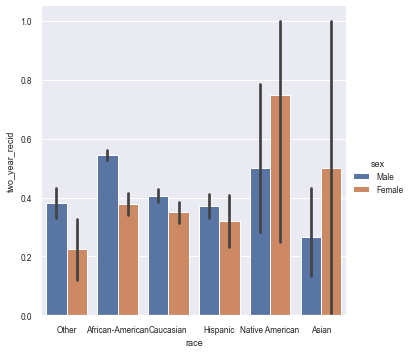

In [220]:
# plotting the distribution of race in the propublica data

sns.set(font_scale = .75)

sns.catplot(x="race", y="two_year_recid", kind="bar",hue="sex" ,data=two_years)


We can see that Native Americans and African-american have a higher likelihood to recidivate

<AxesSubplot:xlabel='race', ylabel='count'>

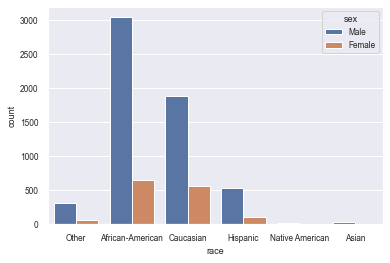

In [221]:
sns.set(font_scale = .75)

sns.countplot(x="race",hue="sex",  data=two_years)

We can also observe that there are many more males in the dataset

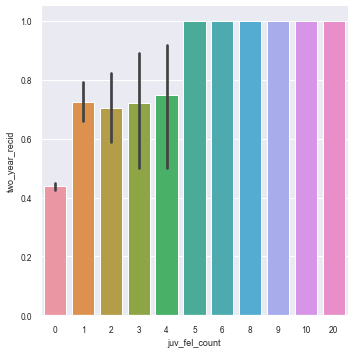

In [222]:
sns.set(font_scale = .75)

sns.catplot(x="juv_fel_count", y="two_year_recid", kind="bar" ,data=two_years)

The juvenile felony counts seem to have an impact on recidivism as well.

<AxesSubplot:xlabel='juv_fel_count', ylabel='count'>

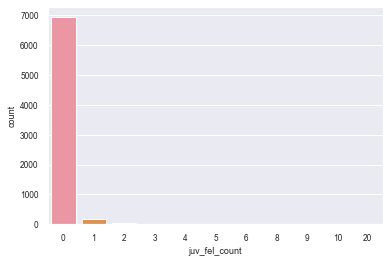

In [223]:
sns.set(font_scale = .75)

sns.countplot(x="juv_fel_count",data=two_years)

Overall, however, we can observe that there exist very few poeple with juvenile felony counts.

<AxesSubplot:xlabel='charge_degree', ylabel='count'>

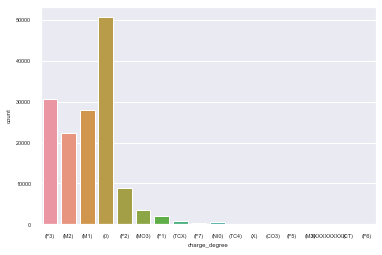

In [224]:
sns.set(font_scale =.5)

sns.countplot(x="charge_degree",data=charge)

As we can see there are many charging degrees present in the raw data

<AxesSubplot:xlabel='c_charge_degree', ylabel='count'>

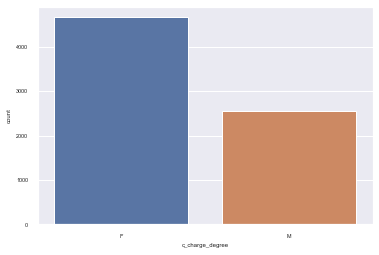

In [225]:
sns.countplot(x= "c_charge_degree", data = two_years)

However, comparing to the data used by ProPublica there exist only two charge degrees. As such we will try to re-classify the charge degrees to not over-generalize our data but also to have a less detailed view than as given through the charge degrees in the raw data.

- We use the following 7 charge degrees: (F1)", "(F2)", "(F3)", "(M1)", "(M2)", "(0) for our model, which in total make up for 96% of the data
- The remaining charge degrees are: `'(MO3)', '(TCX)', '(F7)', '(NI0)', '(TC4)', '(X)', '(CO3)', '(F5)', 'XXXXXXXXXX', '(CT)', '(F6)', '(M3)'` which we will try to group into the 6 chosen charge degrees

Since the charge degrees are categorized based on the severity of the charges (therefore, it is normal to find the same charge type in 2 different charge degrees) and the information regarding the severity of the charges are not available to us, we decide that we will NOT go in favor of the defendants. 
This means that: <b> If the degree can be grouped into 2 charge degrees, we will decide for the more severve group <b> (if no further argument is available)

### <a name="charge-deg"></a>Explanation & Exploration - Charge Degrees

<b> 4.1 Charge Degree: M03 <b>

In [226]:
# List of all the charge types in M03
print(charge[charge["charge_degree"] == "(MO3)"]["charge"].unique())

['Public Consumption Of Alcohol' 'Sleeping On Municipal Beaches'
 'Open Container-FL' 'Petit Theft' 'Trespass' 'Battery' 'Public Indecency'
 'Alcoholic Beverage Violation-FL' 'Intoxicating Beverages'
 'Tresps Privt Prop/Notice By Mgr' 'Municipal Ord/Criminal/Charge'
 'Animals Proh on Beach/Brdwlk' 'Poss Of Controlled Substance'
 'Loud Music Between 9 pm- 7 am' 'Disorderly Conduct'
 'Resisting W/O Violence' 'Loiter Or Prowl' 'Trespass Private Property'
 'Possession Of Paraphernalia' 'Prostitution/Lewdness/Assign'
 'Public Indecency/Exposing' 'Lewd/Assignation/Prostitution'
 'Soliciting For Prostitution' 'Criminal Attempt' 'Loitering/Prowling'
 'Loitering' 'DOC/Engage In Fighting' 'Battery Spouse Or Girlfriend'
 'Alcohol Consumption Violation' 'Sell/Disp Merch W/O Permit'
 'Municipal Ord/System Charge' 'Drinking Alcohol In Public'
 'Lodge In Open/ Park Closed' 'Sleep On Municipal Beaches'
 'Possession Of  Paraphernalia' 'Consume Alcoholic Bev Pub'
 'Unlaw Conduct Business W/O Lic' 'Loite

In [227]:
MO3 = charge[charge["charge_degree"] == "(MO3)"]["charge"]

print("The total number of charges in MO3:", MO3.count())
print("The total number of charges that are related to Alcohol:", MO3.str.contains("Drink|Alcohol|Intoxicat|Bev|Drunk|DOC", regex=True).sum(), "which makes up for", np.round((MO3.str.contains("Drink|Alcohol|Intoxicat|Bev|Drunk|DOC", regex=True).sum() / MO3.count())*100,2),"percent")

The total number of charges in MO3: 3520
The total number of charges that are related to Alcohol: 860 which makes up for 24.43 percent


In [228]:
M1 = charge[charge["charge_degree"] == "(M1)"]["charge"]
M2 = charge[charge["charge_degree"] == "(M2)"]["charge"]

print("The total number of charges that are related to Alcohol in M1:", M1.str.contains("Drink|Alcohol|Intoxicat|Bev|Drunk|DOC", regex=True).sum())
print("The total number of charges that are related to Alcohol in M2:", M2.str.contains("Drink|Alcohol|Intoxicat|Bev|Drunk|DOC", regex=True).sum())

The total number of charges that are related to Alcohol in M1: 103
The total number of charges that are related to Alcohol in M2: 297


MO3 contains different types of charges, where one significant pattern we found is charges related to Drinking/Alcohol (25%). With the same keywords, we check M1, M2 and 0 and saw that the degree that has the most instances related to Alcohol is M2. The rest of the charge types (includung:  can be categorized under M2 or 0, but because we are going against the defendants, we will group MO3 under M2 

<b> 4.2 Charge Degree: TCX <b>

In [229]:
# List of all the charge types in TCX
print(charge[charge["charge_degree"] == "(TCX)"]["charge"].unique())

['Expired DL/More than 4 Months' 'License Suspended Revoked'
 'Reckless Driving' 'Driving License Suspended' 'Expired Tag'
 'Driving Under The Influence' 'License Not Carried'
 'Operating W/O License' 'Fail Register Motor Vehicle' None
 'Flee/ Elude Off/ Not Revkd Court' 'Unregistered Tag Not On'
 'Operate Against Lic/Restriction' 'No Valid License'
 'Transporter License Plate Viol' 'Traffic'
 'Posses/Disply Susp/Revk/Frd DL' 'Fail Apply Lost/Stole Tag/ Decl'
 'Operate Against Lic/Restric' 'DUI Property Damage/Injury'
 'Leave Acc/Attended Veh' 'No Valid Florida DL' 'Fail Disp Registration'
 'Failure Display Registration' 'Unlaw LicTag/Sticker Attach'
 'Registration not Carried' 'Opert With Susp DL 2nd Offens'
 'Financial Responsibility' 'Opert With Susp DL 2nd Offense'
 'Unlaw Use Temporary Tag' 'Racing On Highway'
 'Improper Tags/Out of State' 'No Valid Drivers License'
 'Use Mot Veh In Comm Of Felony' 'Driving Unregistered Moped'
 'Fail Obey Pol Off//Flee' 'Unlawful Lic Use/Display'


In [230]:
TCX = charge[charge["charge_degree"] == "(TCX)"]["charge"]

print("The total number of charges in TCX:", TCX.count())
print("The total number of charges that are related to Road Traffic:", TCX.str.contains("License|Driv|Vehicle|Racing|DL", regex=True).sum(), "which makes up for", np.round((TCX.str.contains("License|Driv|Vehicle|Racing|DL", regex=True).sum() / TCX.count())*100,2),"percent")

The total number of charges in TCX: 880
The total number of charges that are related to Road Traffic: 711 which makes up for 80.8 percent


In [231]:
c0 = charge[charge["charge_degree"] == "(0)"]["charge"]

print("The total number of charges that are related to Road Traffic in M1:", M1.str.contains("License|Driv|Vehicle|Racing|DL", regex=True).sum())
print("The total number of charges that are related to Road Traffic in M2:", M2.str.contains("License|Driv|Vehicle|Racing|DL", regex=True).sum())
print("The total number of charges that are related to Road Traffic in 0:", c0.str.contains("License|Driv|Vehicle|Racing|DL", regex=True).sum())

The total number of charges that are related to Road Traffic in M1: 1767
The total number of charges that are related to Road Traffic in M2: 13247
The total number of charges that are related to Road Traffic in 0: 11113


TCX is strongly leaning toward the category "Road Traffic" and when checking with the same keywords (License|Driv|Vehicle|Racing|DL), we see that M2 and 0 have the most instances for charges related to Road Traffic. Therefore, we decide for M2. 

<b> 4.3 Charge Degree: NI0 <b>

In [232]:
# List of all the charge types in NI0
print(charge[charge["charge_degree"] == "(NI0)"]["charge"].unique())

['Possess Tobacco Product Under 18' 'Violation Of Boater Safety Id'
 'Ride Tri-Rail Without Paying' 'Operate W/O Valid Registration'
 'Careless Operation Of Vessel' 'Vessel Prohibited Activity'
 'Fail To Secure Load' 'Violation Of Navigation Rules'
 'Fish/Hunt/Trap W/O License/Stamp' 'Vessel Safety Equip Violation'
 'Under 18/Smoke On School Grounds'
 'Litter Pub Hghwy/Mot Veh less than 15LBs'
 'Fish/Hunt/Trap W/O License Stamp' 'Excess Speed in Manatee Zone'
 'Fish/Hunt/Trap W/O License' 'Vessel Viol In Restricted Area'
 'Litter On The Highway' 'Fail Disp Proper Light/Shape'
 'Vessel Decal Violation' 'Excess Speed Manatee Zone'
 'Water Ski/Aquaplane Violation' 'Fail Produce Lic/Permit'
 'Damage Park Plant Life' 'Oper Craf 1/2 Hr Prior/Aft Dark'
 'Improperly Registered Vessel' 'Too Fast For Conditions State Park'
 'Violation Of Diver Down Flag' 'Vessel Reg/Number/Decal Viol']


In [233]:
NI0 = charge[charge["charge_degree"] == "(NI0)"]["charge"]

print("The total number of charges in NI0:", NI0.count())
print("The total number of charges that are related to Tobacco:", NI0.str.contains("Tobacco|Smoke", regex=True).sum(), "which makes up for", np.round((NI0.str.contains("Tobacco|Smoke", regex=True).sum() / NI0.count())*100,2),"percent")
print("The total number of charges that are related to Under 18:", NI0.str.contains("(?=.*Under)(?=.*18)", regex=True).sum(), "which makes up for", np.round((NI0.str.contains("(?=.*Under)(?=.*18)", regex=True).sum() / NI0.count())*100,2),"percent")

The total number of charges in NI0: 496
The total number of charges that are related to Tobacco: 179 which makes up for 36.09 percent
The total number of charges that are related to Under 18: 179 which makes up for 36.09 percent


The patterns we found in NI0 is, one dominant type is charges related to using Tobacco/Smoking and also one-third of the charges concerns defendants under 18. Therefore, we feel like the severity of this degree is not so significant and choose to categorize it under 0

<b> 4.4 Charge Degree: TC4 <b>

In [234]:
# List of all the charge types in TC4
print(charge[charge["charge_degree"] == "(TC4)"]["charge"].unique())

['Driving Under The Influence' 'DWI Injury Persons Property'
 'Refuse To Submit To Breathalyzer' 'Driving Under the Influence'
 'Unlawful Blood Alcohol Level']


In [235]:
F3 = charge[charge["charge_degree"] == "(F3)"]["charge"]

print("The total number of charges that are related to DUI in F3:", F3.str.contains("(?=.*Driving)(?=.*Influence)").sum())
print("The total number of charges that are related to DWI in F3:", F3.str.contains("DWI", regex=True).sum())
print("The total number of charges that are related to DUI in M1:", M1.str.contains("(?=.*Driving)(?=.*Influence)").sum())
print("The total number of charges that are related to DWI in M1:", M1.str.contains("DWI", regex=True).sum())
print("The total number of charges that are related to DUI in M2:", M2.str.contains("(?=.*Driving)(?=.*Influence)").sum())
print("The total number of charges that are related to DWI in M2:", M2.str.contains("DWI", regex=True).sum())

The total number of charges that are related to DUI in F3: 57
The total number of charges that are related to DWI in F3: 4
The total number of charges that are related to DUI in M1: 1131
The total number of charges that are related to DWI in M1: 0
The total number of charges that are related to DUI in M2: 67
The total number of charges that are related to DWI in M2: 0


Looking at the list, it can be said that TC4 only concerns Driving Under the Influence (DUI) and Driving While Intoxicated (DWI). Checking this criteria in F3, M1 and M2 we see the most instances related to DUI/DWI are found under M1. Therefore, we categorize TC4 under M1 

<b> 4.5 Charge Degree: X <b>

In [236]:
# List of all the charge types in X
print(charge[charge["charge_degree"] == "(X)"]["charge"].unique())

[None 'Reckless Driving' 'Booked']


In [237]:
print("The total number of charges that are related to Reckless Driving in F3:", F3.str.contains("(?=.*Reckles)(?=.*Driving)").sum())
print("The total number of charges that are related to Reckless Driving in M1:", M1.str.contains("(?=.*Reckles)(?=.*Driving)").sum())
print("The total number of charges that are related to Reckless Driving in M2:", M2.str.contains("(?=.*Reckles)(?=.*Driving)").sum())
print("The total number of charges that are related to Reckless Driving in 0:", c0.str.contains("(?=.*Reckles)(?=.*Driving)").sum())

The total number of charges that are related to Reckless Driving in F3: 4
The total number of charges that are related to Reckless Driving in M1: 24
The total number of charges that are related to Reckless Driving in M2: 311
The total number of charges that are related to Reckless Driving in 0: 5


We checked for Reckless Driving in F3, M1, M2 and 0 and found that most charges related to Reckless Driving are under M2. Therfore, we categorize X under M2

<b> 4.6 Charge Degree: CO3 <b>

In [238]:
# List of all the charge types in CO3
print(charge[charge["charge_degree"] == "(CO3)"]["charge"].unique())

['Drink/Licensed/Establisment' 'DOC/Sleep In Prohibited Area'
 'DOC/Open Container/Bus Facility' 'Violation Broward Co Ordinance'
 'Drink Near Licensed Establishm' 'DOC/Alcoholic Bev/Bus Facility'
 'Drink/Premises Licensed Estab' 'DOC At Main Bus Facility'
 'Consume Alcoh Bev Where Prohib' 'Open Container Alcohol - MV'
 'Loitering/Prowling' 'Littering In A Public Place' None
 'Consume Alcohol In Public' 'Disorderly Conduct' 'Urinating In Public'
 'Oper CMV W/O Distinct Lettering' 'Loitering' 'Misuse Of Bus Transfers']


In [239]:
CO3 = charge[charge["charge_degree"] == "(CO3)"]["charge"]

print("The total number of charges in CO3:", CO3.count())
print("The total number of charges that are related to Alcohol:", CO3.str.contains("Drink|Alcohol|DOC|Bev|Drunk", regex=True).sum(), "which makes up for", np.round((CO3.str.contains("Drink|Alcohol|Intoxicat|Bev|Drunk", regex=True).sum() / CO3.count())*100,2),"percent")

The total number of charges in CO3: 125
The total number of charges that are related to Alcohol: 105 which makes up for 50.4 percent


More than half of the charges in CO3 are related to Drinking/Alcohol and therefore CO3 can be put under M2 (see explanation under 4.1). The other ones (including: Loitering, Littering, Urinating, Disorderly Conduct etc.) could be in 0, but because of our decision of going unfavored of the defendants, we will decide for M2. 

<b> 4.7 Charge Degree: M3

In [240]:
# List of all the charge types in M3
print(charge[charge["charge_degree"] == "(M3)"]["charge"].unique())

['Poss Of RX Without RX']


M3 can be grouped into M2 since both are considered misdemeanors but the severity is not as significant as charges in M1.

<b> 4.8 Charge Degree: F7 <b>

In [241]:
# List of all the charge types in F7
print(charge[charge["charge_degree"] == "(F7)"]["charge"].unique())

['Burglary Struc/dwel/conv Armed' 'Burglary Dwelling Armed'
 'Burglary Structure Armed' 'Possess/Use Weapon 1 Deg Felon'
 'Burglary Assault/battery Armed' 'Burglary Dwelling Assault/Batt'
 'Burglary Struct/conv Asslt/bat' 'Armed Burglary'
 'Burglary Conveyance Armed' 'Burglary With Assault/battery'
 'Burglary Conveyance Assault/Bat' 'Burglary Structure Assault/Batt'
 'Murder 2nd Degree W/Deadly Wep' 'Sexual Battery / Vict 12 Yrs +'
 'Possess Weapon 1 Deg Felon' 'Armed Kidnapping'
 'Armed Sex Batt/vict 12 Yrs +' 'Tampering/Felony Life/Capital Proc'
 'Burglary Dwelling Assault/batt' None 'Kidnapping / Domestic Violence'
 'Sex Battery Deft 17-/Vict 11-' "Armed Del Cocaine 1000' School"
 'Sexual Battery - Great Force' 'Armed Trafficking In Cocaine'
 'Burglary Conveyance Assault/bat' 'Burglary Struc/Dwel/Conv Armed'
 'Burglary Assault/Battery Armed']


In [242]:
F7 = charge[charge["charge_degree"] == "(F7)"]["charge"]

print("The total number of charges in F7:", F7.count())
print("The total number of charges that are related to Burglary:", F7.str.contains("Burglary", regex=True).sum(), "which makes up for", np.round((F7.str.contains("Burglary", regex=True).sum() / F7.count())*100,2),"percent")
print("The total number of charges that are related to Armed Burglary:", F7.str.contains("(?=.*Burglary)(?=.*Armed)").sum(), "which makes up for", np.round((F7.str.contains("(?=.*Burglary)(?=.*Armed)").sum() / F7.count())*100,2),"percent")
print("The total number of charges that are related to Assault Burglary:", F7.str.contains("(?=.*Burglary)(?=.*Assault)").sum(), "which makes up for", np.round((F7.str.contains("(?=.*Burglary)(?=.*Assault)").sum() / F7.count())*100,2),"percent")
print("The total number of charges that are related to Dwelling Burglary:", F7.str.contains("(?=.*Burglary)(?=.*Dwelling)").sum(), "which makes up for", np.round((F7.str.contains("(?=.*Burglary)(?=.*Dwelling)").sum() / F7.count())*100,2),"percent")

The total number of charges in F7: 429
The total number of charges that are related to Burglary: 356 which makes up for 82.98 percent
The total number of charges that are related to Armed Burglary: 162 which makes up for 37.76 percent
The total number of charges that are related to Assault Burglary: 142 which makes up for 33.1 percent
The total number of charges that are related to Dwelling Burglary: 127 which makes up for 29.6 percent


Burglary is both listed under F1 and F2. We check the types of charges related to "Burglary" in these 2 degrees and found that more instances are found in F2. Also, F2 covers charge types that more similar to the ones in F7. Therefore, we categorize F7 under F2

In [243]:
F1 = charge[charge["charge_degree"] == "(F1)"]["charge"]
F2 = charge[charge["charge_degree"] == "(F2)"]["charge"]

print("The total number of charges that are related to Burglaryin F1:", F1.str.contains('Burglary.*').sum())
print("The total number of charges that are related to Burglaryin F2:", F2.str.contains('Burglary.*').sum())

The total number of charges that are related to Burglaryin F1: 88
The total number of charges that are related to Burglaryin F2: 1875


In [244]:
F1[F1.str.match(r'(Burglary.*)')==True].unique()

array(['Burglary With Assault/battery', 'Burglary Damage Property>$1000',
       'Burglary Use Vehicle as Instru', 'Burglary With Assault/Battery'],
      dtype=object)

In [245]:
F2[F2.str.match(r'(Burglary.*)')==True].unique()

array(['Burglary Unoccupied Dwelling', 'Burglary Dwelling Occupied',
       'Burglary Structure Occupied', 'Burglary Struct/conv Dwel/occp',
       'Burglary Dwelling Assault/Batt', 'Burglary Of A Dwelling',
       'Burglary Conveyance Occupied', 'Burglary With Battery',
       'Burglary Dwelling Armed', 'Burglary Struct/conv Asslt/bat',
       'Burglary Structure Assault/Batt',
       'Burglary Damage Property>$1000', 'Burglary Struct Unoccup Mask',
       'Burglary Dwell/Stealthy Manner', 'Burglary Dwelling Assault/batt',
       'Burglary Of Motor Vehicle', 'Burglary Dwelling Unoccup',
       'Burglary Struct/Conv Dwel/Occp'], dtype=object)

<b> 4.9 Charge Degree: F5 <b>

In [246]:
# List of all the charge types in F5
print(charge[charge["charge_degree"] == "(F5)"]["charge"].unique())

['Sex Battery Deft 18+/Vict 11-' 'Armed Sexual Battery']


In [247]:
print("The total number of charges that are related to Sexual Battery in F1:", F1.str.contains("(?=.*Sex)(?=.*Battery)").sum())
print("The total number of charges that are related to Sexual Battery in F2:", F2.str.contains("(?=.*Sex)(?=.*Battery)").sum())

The total number of charges that are related to Sexual Battery in F1: 52
The total number of charges that are related to Sexual Battery in F2: 81


In [248]:
F1[F1.str.match(r'(?=.*Sex)(?=.*Battery)')==True].unique()

array(['Sex Battery Deft 17-/Vict 11-', 'Sex Battery Deft 18+/Vict 11-',
       'Sexual Battery Victim 12 Yrs +', 'Sexual Battery Victim Coerced',
       'Sex Battery Vict Incapacitated', 'Attempted Sexual Battery',
       'Sexual Battery / Vict 12 Yrs +', 'Sex Battery Vict Mental Defect',
       'Sexual Battery Victim Helpless'], dtype=object)

In [249]:
F2[F2.str.match(r'(?=.*Sex)(?=.*Battery)')==True].unique()

array(['Armed Sexual Battery', 'Sexual Battery / Vict 12 Yrs +',
       'Sex Battery Deft 18+/Vict 11-', 'Sexual Battery Victim Helpless'],
      dtype=object)

Both F1 and F2 have charges related to Sex Battery but F2 have more cases (81 vs. 52) and also F2 includes both types that are in F5. Therefore, we categorize F5 under F2

<b> 4.10 Charge Degree: CT <b>

In [250]:
# List of all the charge types in CT
print(charge[charge["charge_degree"] == "(CT)"]["charge"].unique())

['Contempt/Fail To Appear/Summons' 'Contempt Of Court']


In [251]:
print("The total number of charges that are related to Contempt in F3:", F3.str.contains("Contempt", regex=True).sum())
print("The total number of charges that are related to Contempt in 0:", c0.str.contains("Contempt", regex=True).sum())

The total number of charges that are related to Contempt in F3: 7
The total number of charges that are related to Contempt in 0: 5


CT includes exclusively charges related to Contempt. We check the keyword in other charge degrees and found that only F3 and 0 have charges related to Contempt. Therefore, we categorize CT under F3 (with consideration of going against the defendants)

<b> 4.11 Charge Degree F6 <b>

In [252]:
# List of all the charge types in F6
print(charge[charge["charge_degree"] == "(F6)"]["charge"].unique())

['Murder in the First Degree' None]


In [253]:
print("The total number of charges that are related to First Degree Murder in F1:", F1.str.contains("(?=.*Murder)(?=.*First)").sum())
print("The total number of charges that are related to First Degree Murder in F2:", F2.str.contains("(?=.*Murder)(?=.*First)").sum())


The total number of charges that are related to First Degree Murder in F1: 30
The total number of charges that are related to First Degree Murder in F2: 2


Both F1 and F2 cover "Murder in the First Degree" but there are more instances found in F1. Therefore, we categorize F6 under F1

Since we can only know about charges in the charging table at the time of the screening, we will drop all charges with negative values

In [254]:
# Dropping of negative values

charge = charge[charge["days_since_compas"] > -30]

We continue by encoding the charge degrees into the respective new categories described above. For further processing purposes, we chose numerical variables ranging the severity of the charge from 0-5.

In [255]:
# The following charge degrees are given in the charge table

charge_list_old = list(charge["charge_degree"].unique())

print(f"The old charge degrees: {charge_list_old}")

# Given the explanation, we encoded the charge degrees as follows:

charge = charge.replace({'(0)':0,'(M2)':1,'(M1)':2,'(F3)':3,'(F2)':4, '(F1)':5, '(MO3)':1, '(TCX)':1,'(F7)':4,'(NI0)': 0, '(TC4)':2, '(X)':1, '(CO3)':1,'(F5)':4, '(M3)':1,'XXXXXXXXXX':0,'(CT)':1, '(F6)':5})

charge_list_new = charge["charge_degree"].unique()

print(f"The new charge degrees: {charge_list_new}")

The old charge degrees: ['(F3)', '(M2)', '(0)', '(F2)', '(M1)', '(MO3)', '(TCX)', '(F1)', '(F7)', '(NI0)', '(TC4)', '(X)', '(CO3)', '(F5)', '(M3)', 'XXXXXXXXXX', '(CT)', '(F6)']
The new charge degrees: [3 1 0 4 2 5]


<AxesSubplot:xlabel='charge_degree', ylabel='count'>

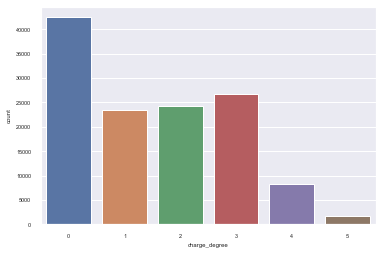

In [256]:
sns.set(font_scale =.5)

sns.countplot(x="charge_degree",data=charge)

Based on the new encoding, we introduce a new predictor for each charging degree, that will be 1, given that the charge is in that category or 0 otherwise.

### <a name="agg"></a>Data Aggregation and Feature Engineering

We now introduce a new feature that counts the amount of charges for each defendant within each degree.

In [257]:
# given the new encoding, we introduce a new column for each degree that counts the occurence

for degree in np.sort(charge_list_new):
    charge['deg_'+str(degree)] = charge['charge_degree'].apply(lambda x: 1 if x == degree else 0)
    
charge.head(5)

,id,case_type,case_number,filing_date,offense_date,charge_number,charge_degree,charge,date_charge_filed,filing_type,filing_agency,name,days_since_compas,statute,person_id,deg_0,deg_1,deg_2,deg_3,deg_4,deg_5
0,1,,13005832CF10A,1800-01-01 00:00:00.000000,2013-04-23 00:00:00.000000,1,3,Driving While License Revoked,2013-04-23 00:00:00,No Information/ Transfer to Misdemeanor,Fort Lauderdale PD,aajah herrington,1,322.34(5),533,0,0,0,1,0,0
1,2,,13005832CF10A,1800-01-01 00:00:00.000000,2013-04-23 00:00:00.000000,2,1,Petit Theft,2013-04-23 00:00:00,Transfer to County Court,Fort Lauderdale PD,aajah herrington,1,812.014(3)(a),533,0,1,0,0,0,0
4,5,,11065568TI30A,1800-01-01 00:00:00.000000,2011-07-03 00:00:00.000000,1,0,Violation Of Move Over Law,2011-07-03 00:00:00,None,Broward Sheriff Office,aajah herrington,661,316.126(1)(B)1,533,1,0,0,0,0,0
5,6,,11065568TI30A,1800-01-01 00:00:00.000000,2011-07-03 00:00:00.000000,2,0,Pers/Inj/Prot/Ins Require,2011-07-03 00:00:00,None,Broward Sheriff Office,aajah herrington,661,316.646(1),533,1,0,0,0,0,0
6,7,,12039549TI30A,1800-01-01 00:00:00.000000,2012-03-03 00:00:00.000000,1,0,Pers/Inj/Prot/Ins Require,2012-03-03 00:00:00,None,Broward Sheriff Office,aajah herrington,417,316.646(1),533,1,0,0,0,0,0


In order to introduce one more feature, the age at the charge, we merge our dataframe with the compass two year dataframe to receive the age and date of birth

In [258]:
dob_sub = two_years[["id", "dob", "age" ,"name"]]

In [259]:
# merging the two datframes based on person_id

dob_charge = charge.merge(dob_sub, how = "left", left_on = "person_id", right_on ="id")

In [260]:
# our dataframe now looks like 

dob_charge.head(5)

,id_x,case_type,case_number,filing_date,offense_date,charge_number,charge_degree,charge,date_charge_filed,filing_type,filing_agency,name_x,days_since_compas,statute,person_id,deg_0,deg_1,deg_2,deg_3,deg_4,deg_5,id_y,dob,age,name_y
0,1,,13005832CF10A,1800-01-01 00:00:00.000000,2013-04-23 00:00:00.000000,1,3,Driving While License Revoked,2013-04-23 00:00:00,No Information/ Transfer to Misdemeanor,Fort Lauderdale PD,aajah herrington,1,322.34(5),533,0,0,0,1,0,0,533.0,1992-06-02,23.0,aajah herrington
1,2,,13005832CF10A,1800-01-01 00:00:00.000000,2013-04-23 00:00:00.000000,2,1,Petit Theft,2013-04-23 00:00:00,Transfer to County Court,Fort Lauderdale PD,aajah herrington,1,812.014(3)(a),533,0,1,0,0,0,0,533.0,1992-06-02,23.0,aajah herrington
2,5,,11065568TI30A,1800-01-01 00:00:00.000000,2011-07-03 00:00:00.000000,1,0,Violation Of Move Over Law,2011-07-03 00:00:00,None,Broward Sheriff Office,aajah herrington,661,316.126(1)(B)1,533,1,0,0,0,0,0,533.0,1992-06-02,23.0,aajah herrington
3,6,,11065568TI30A,1800-01-01 00:00:00.000000,2011-07-03 00:00:00.000000,2,0,Pers/Inj/Prot/Ins Require,2011-07-03 00:00:00,None,Broward Sheriff Office,aajah herrington,661,316.646(1),533,1,0,0,0,0,0,533.0,1992-06-02,23.0,aajah herrington
4,7,,12039549TI30A,1800-01-01 00:00:00.000000,2012-03-03 00:00:00.000000,1,0,Pers/Inj/Prot/Ins Require,2012-03-03 00:00:00,None,Broward Sheriff Office,aajah herrington,417,316.646(1),533,1,0,0,0,0,0,533.0,1992-06-02,23.0,aajah herrington


We now compue the age at charge, by calculating the delta of the filed charge and the birth date. It is important to note that the age given is not exact since we cannot perfectly account for leap years and will assume a year has 365.25 days.

In [261]:
# convert the relevant features in the correct datatypes

dob_charge[["date_charge_filed", "dob"]] = dob_charge[["date_charge_filed", "dob"]].astype('datetime64[ns]')

In [262]:
# calculate the new feature

dob_charge["age_at_charge"] = ((dob_charge["date_charge_filed"] - dob_charge["dob"]) / (365.25)).dt.days

In [263]:
# our dataframe now looks like

dob_charge.head()

,id_x,case_type,case_number,filing_date,offense_date,charge_number,charge_degree,charge,date_charge_filed,filing_type,filing_agency,name_x,days_since_compas,statute,person_id,deg_0,deg_1,deg_2,deg_3,deg_4,deg_5,id_y,dob,age,name_y,age_at_charge
0,1,,13005832CF10A,1800-01-01 00:00:00.000000,2013-04-23 00:00:00.000000,1,3,Driving While License Revoked,2013-04-23,No Information/ Transfer to Misdemeanor,Fort Lauderdale PD,aajah herrington,1,322.34(5),533,0,0,0,1,0,0,533.0,1992-06-02,23.0,aajah herrington,20.0
1,2,,13005832CF10A,1800-01-01 00:00:00.000000,2013-04-23 00:00:00.000000,2,1,Petit Theft,2013-04-23,Transfer to County Court,Fort Lauderdale PD,aajah herrington,1,812.014(3)(a),533,0,1,0,0,0,0,533.0,1992-06-02,23.0,aajah herrington,20.0
2,5,,11065568TI30A,1800-01-01 00:00:00.000000,2011-07-03 00:00:00.000000,1,0,Violation Of Move Over Law,2011-07-03,None,Broward Sheriff Office,aajah herrington,661,316.126(1)(B)1,533,1,0,0,0,0,0,533.0,1992-06-02,23.0,aajah herrington,19.0
3,6,,11065568TI30A,1800-01-01 00:00:00.000000,2011-07-03 00:00:00.000000,2,0,Pers/Inj/Prot/Ins Require,2011-07-03,None,Broward Sheriff Office,aajah herrington,661,316.646(1),533,1,0,0,0,0,0,533.0,1992-06-02,23.0,aajah herrington,19.0
4,7,,12039549TI30A,1800-01-01 00:00:00.000000,2012-03-03 00:00:00.000000,1,0,Pers/Inj/Prot/Ins Require,2012-03-03,None,Broward Sheriff Office,aajah herrington,417,316.646(1),533,1,0,0,0,0,0,533.0,1992-06-02,23.0,aajah herrington,19.0


Since we have the counts of each defendant and their respective charge degrees based on our encoding, we now aggregate over the defendants id, by keepng the highest prior charging degree and the sum within each of the charging categories, the max charge at one offense incident and the minimal age at which a defendant was charged.

In [264]:
# using that information, we construct an aggregated dataframe by extracting the highest charging degree per person and the amount of times within each individual group a person commited a crime

dob_charge = dob_charge.groupby("person_id", as_index = False).agg({"charge_degree":"max","deg_0":"sum", "deg_1":"sum", "deg_2":"sum", "deg_3":"sum", "deg_4":"sum", "deg_5":"sum", "charge_number":"max", "age_at_charge":"min"})

charge_agg = dob_charge.rename(columns={'person_id':'id','charge_degree':'highest_degree_charged', 
                                        'deg_0':'count_deg_0', 'deg_1':'count_deg_1', 'deg_2':'count_deg_2', 
                                        'deg_3':'count_deg_3', 'deg_4':'count_deg_4', 'deg_5':'count_deg_5', 
                                        "charge_number":"max_charge_incid", "age_at_charge":"ear_charge_age"})

charge_agg.drop_duplicates()


charge_agg.head(10)

,id,highest_degree_charged,count_deg_0,count_deg_1,count_deg_2,count_deg_3,count_deg_4,count_deg_5,max_charge_incid,ear_charge_age
0,1,3,4,0,1,1,0,0,2,62.0
1,3,3,0,0,0,1,0,0,1,31.0
2,4,3,6,3,6,4,0,0,5,17.0
3,5,3,1,1,2,1,0,0,2,14.0
4,6,4,1,0,1,1,1,0,2,36.0
5,7,2,0,0,1,0,0,0,1,42.0
6,8,4,4,3,4,13,3,0,4,19.0
7,9,4,9,3,1,2,1,0,2,29.0
8,10,2,0,0,1,0,0,0,1,37.0
9,11,3,3,0,1,1,0,0,4,NaN


 We can observe that there are still several defendants for which no age was available. It will be shown later however that due to merging the dataframe with the rest of compas two years, none of these defendants will remain.

<AxesSubplot:xlabel='highest_degree_charged', ylabel='Count'>

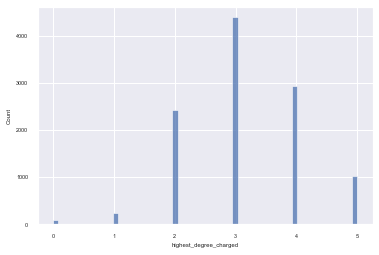

In [265]:
sns.histplot(x="highest_degree_charged", data = charge_agg)

We can see that the highest degrees charged are almost normally distributed

Given this aggregated new view on the charges, we now merge the charge data back with the compas score two years that was used by ProPublica.

In [266]:
# merging with compas two years 

compas_merge = charge_agg.merge(two_years, how = "inner", on="id")

In [267]:
# we convcert the earliest age at charge to integer

compas_merge["ear_charge_age"].astype("uint8")

0       62
1       31
2       17
3       14
4       36
        ..
7197    21
7198    20
7199    55
7200    19
7201    21
Name: ear_charge_age, Length: 7202, dtype: uint8

We can also now show that no NaN values remain for the earliest charge age and that the feature is never bigger than the actual age of the defendant.

In [268]:
# empty result

compas_merge[compas_merge["age"] < compas_merge["ear_charge_age"]]

,id,highest_degree_charged,count_deg_0,count_deg_1,count_deg_2,count_deg_3,count_deg_4,count_deg_5,max_charge_incid,ear_charge_age,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid


In [269]:
# no NA values left

compas_merge["ear_charge_age"].isna().value_counts()

False    7202
Name: ear_charge_age, dtype: int64

In [270]:
# the current shape of our df

compas_merge.shape

(7202, 62)

Now we include our last predictor, the marital status, by subseting the compas table and only keeping the unique id's. 

In [271]:
# subseting compas dataframe for last needed predictor and renaming column to be merged

compas = compas[["person_id", "marital_status"]].drop_duplicates().rename(columns={'person_id':'id'})

compas.head(5)

,id,marital_status
0,1,Single
3,2,Single
6,3,Single
9,4,Single
12,5,Single


<AxesSubplot:xlabel='marital_status', ylabel='count'>

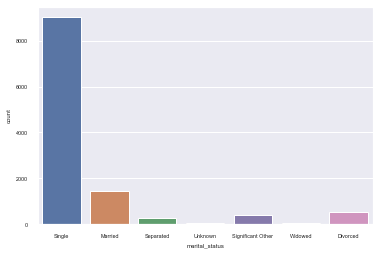

In [272]:
sns.set(font_scale =.5)

sns.countplot(x="marital_status",data=compas)

We merge the marital status back with the  rest of the data.

In [273]:
# merging compas with people to df

df = compas_merge.merge(compas, how="inner", on="id")

df.head(5)

df.shape

(7256, 63)

In [274]:
df.head()

,id,highest_degree_charged,count_deg_0,count_deg_1,count_deg_2,count_deg_3,count_deg_4,count_deg_5,max_charge_incid,ear_charge_age,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,marital_status
0,1,3,4,0,1,1,0,0,2,62.0,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,Single
1,3,3,0,0,0,1,0,0,1,31.0,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,Single
2,4,3,6,3,6,4,0,0,5,17.0,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,Single
3,5,3,1,1,2,1,0,0,2,14.0,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0,Single
4,6,4,1,0,1,1,1,0,2,36.0,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,Married


<AxesSubplot:xlabel='marital_status', ylabel='count'>

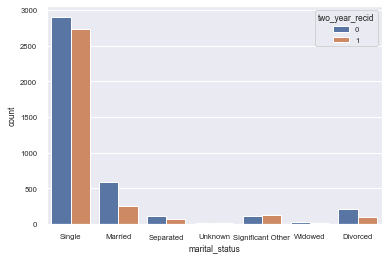

In [275]:
sns.set(font_scale = .7)

sns.countplot(x="marital_status", hue ="two_year_recid", data= df)

As evident by the bar graph, the the amount of people that recidivised differs between different marital status.

<AxesSubplot:xlabel='highest_degree_charged', ylabel='count'>

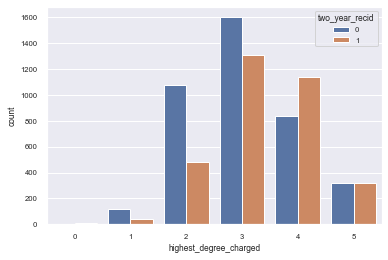

In [276]:
# reasoning to drop 0

sns.countplot(x="highest_degree_charged", hue ="two_year_recid", data= df)


Also the amount of people that recidivised changes depending on the highest degree a defendant was charged with.

### <a name="clean"></a>Final Data Cleaning before modeling

Since all the relevant data is combined into one dataframe including all predictors needed, we will do some more data cleaning and transforming before the start of the modeling. <br>
In these steps we will also reproduce the initial data cleaning by ProPublica; only including people with a highest charging degree of > 0, excluding people with is_recid = -1 and excluding the screening arrest > and < 30 days and when no score_text is given.


In [277]:
# First we exclude all people that have a highest charging degree of only 0, since they are only related to traffic accidents and as such won't be regarded as a misdemeanor or felony

df = df[df["highest_degree_charged"] != 0]

# we build an additional predictor, counting the total amount of charges throughout all degrees

df["total_prior_charges"] = df[["count_deg_0", "count_deg_1", "count_deg_2", "count_deg_3", "count_deg_4", "count_deg_5"]].sum(axis= 1)

# we now exclude also all cases where there is no compas case given at all 

df = df[df["is_recid"] != -1]

In [278]:
df.head(10)

,id,highest_degree_charged,count_deg_0,count_deg_1,count_deg_2,count_deg_3,count_deg_4,count_deg_5,max_charge_incid,ear_charge_age,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,marital_status,total_prior_charges
0,1,3,4,0,1,1,0,0,2,62.0,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,Single,6
1,3,3,0,0,0,1,0,0,1,31.0,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,Single,1
2,4,3,6,3,6,4,0,0,5,17.0,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,Single,19
3,5,3,1,1,2,1,0,0,2,14.0,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0,Single,5
4,6,4,1,0,1,1,1,0,2,36.0,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,Married,4
5,7,2,0,0,1,0,0,0,1,42.0,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,0,1,0,0,0,0.0,2013-11-30 04:50:18,2013-12-01 12:28:56,13022355MM10A,2013-11-30,NaN,0.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-11-30,Risk of Violence,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0,Separated,1
6,8,4,4,3,4,13,3,0,4,19.0,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,0,6,0,0,14,-1.0,2014-02-18 05:08:24,2014-02-24 12:18:30,14002304CF10A,2014-02-18,NaN,1.0,F,Possession Burglary Tools,1,14004485CF10A,(F2),0.0,2014-03-31,Poss of Firearm by Convic Felo,2014-03-31,2014-04-18,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,6,Medium,2014-02-19,Risk of Violence,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1,Single,27
7,9,4,9,3,1,2,1,0,2,29.0,steven stewart,steven,stewart,2013-08-30,Male,1973-02-25,43,25 - 45,Other,0,4,0,0,3,-1.0,2013-08-29 08:55:23,2013-08-30 08:42:13,13012216CF10A,NaN,2013-08-29,1.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-08-30,Risk of Violence,3,Low,2013-08-30,2014-05-22,2014-06-03,3,0,265,0,0,Ma

In [279]:
# we now apply the steps of data cleaning such as propublica

df = (df
      .query('days_b_screening_arrest <= 30 & days_b_screening_arrest >= -30')
      .query('score_text != "N/A"')
     )

We now subset the columns to only include the features that we want for our model.

In [280]:
# we now subset only the columns we will use as a predictor and target 

df = df[["is_recid", 
              "is_violent_recid", 
              "sex", 
              "race", 
              "age",
              "juv_fel_count", 
              "juv_misd_count", 
              "juv_other_count",  
              "marital_status", 
              "highest_degree_charged", 
              "count_deg_0",
              "count_deg_1",
              "count_deg_2",
              "count_deg_3", 
              "count_deg_4", 
              "count_deg_5",
              "total_prior_charges",
              "max_charge_incid",
              "ear_charge_age",
              "two_year_recid"]]

df.head(5)

,is_recid,is_violent_recid,sex,race,age,juv_fel_count,juv_misd_count,juv_other_count,marital_status,highest_degree_charged,count_deg_0,count_deg_1,count_deg_2,count_deg_3,count_deg_4,count_deg_5,total_prior_charges,max_charge_incid,ear_charge_age,two_year_recid
0,0,0,Male,Other,69,0,0,0,Single,3,4,0,1,1,0,0,6,2,62.0,0
1,1,1,Male,African-American,34,0,0,0,Single,3,0,0,0,1,0,0,1,1,31.0,1
2,1,0,Male,African-American,24,0,0,1,Single,3,6,3,6,4,0,0,19,5,17.0,1
5,0,0,Male,Other,44,0,0,0,Separated,2,0,0,1,0,0,0,1,1,42.0,0
6,1,0,Male,Caucasian,41,0,0,0,Single,4,4,3,4,13,3,0,27,4,19.0,1


In [281]:
df_sub = df[["two_year_recid","ear_charge_age" ]]

conditions = [
    (df["ear_charge_age"] <= 20) ,
    (df["ear_charge_age"] > 20) & (df["ear_charge_age"]  <=30),
    (df["ear_charge_age"] > 30) & (df["ear_charge_age"]  <=40),
    (df["ear_charge_age"] > 40) & (df["ear_charge_age"]  <=50),
    (df["ear_charge_age"] > 50) & (df["ear_charge_age"]  <=60),
    (df["ear_charge_age"] > 60)]

choices = ["<20", "20-30", "30-40", "40-50", "50-60", ">60"]

df_sub["age_cat"] = np.select(conditions, choices)



C:\Users\felix\AppData\Local\Temp/ipykernel_22188/2643943891.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub["age_cat"] = np.select(conditions, choices)


<AxesSubplot:xlabel='age_cat', ylabel='count'>

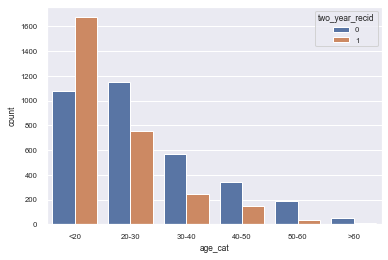

In [282]:
sns.countplot(x="age_cat", hue ="two_year_recid", data= df_sub, order =["<20", "20-30", "30-40", "40-50", "50-60", ">60"] )

Given the visualization above, we can already see that the age ssems to be an important factor with regards to recidivism.

In [283]:
df_sub2 = df[["two_year_recid","max_charge_incid" ]]

#df_sub["ear_charge_age"].sort_values().unique()

conditions = [
    (df["max_charge_incid"] == 1) ,
    (df["max_charge_incid"] > 1) & (df["max_charge_incid"]  <=2),
    (df["max_charge_incid"] > 2) & (df["max_charge_incid"]  <=3),
    (df["max_charge_incid"] > 3) & (df["max_charge_incid"]  <=4),
    (df["max_charge_incid"] > 4) & (df["max_charge_incid"]  <=5),
    (df["max_charge_incid"] > 5)]

choices = ["1", "2", "3", "4", "5", ">5"]

df_sub2["charge_cat"] = np.select(conditions, choices)

C:\Users\felix\AppData\Local\Temp/ipykernel_22188/3578576566.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub2["charge_cat"] = np.select(conditions, choices)


<AxesSubplot:xlabel='charge_cat', ylabel='count'>

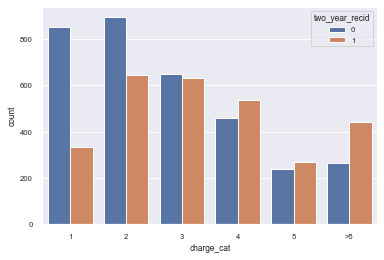

In [284]:
sns.countplot(x="charge_cat", hue ="two_year_recid", data= df_sub2 , order = ["1", "2", "3", "4", "5", ">5"])

Similarly, the amount of charges at a single incidence seems to have an impact on recidivism.

<AxesSubplot:>

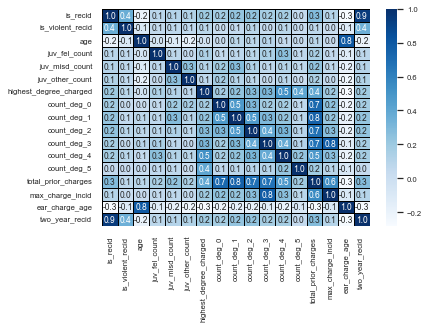

In [285]:
# checking for correlations between variables
correlation = df.corr()

# heatmap of pearson correlation
sns.heatmap(correlation, xticklabels = correlation.columns, yticklabels=correlation.columns, 
            annot = True, fmt=".1f", cmap = "Blues", linewidth=1, linecolor='black' )
# as expected, high correlation between count of charge degrees and the total prior charges

As evident by the table, the individual count degrees correlate with our total priors count, otherwise there are no strong corellations.

We now do two last tweeks to the dataframe, by encode all categorical variables to numeric variables for modeling purposes and then convert them to categorical ones. Since three categorical features, namely sex, race and marital_status are all nominal, we will use dummy encoding for them, for the only ordinal feature, highest_degree_charged, we will use the order given. 

In [286]:
# categorical variables

# the nominal features
sex_cat = df["sex"].unique()

print(sex_cat)

race_cat = df["race"].unique()

print(race_cat)

marital_cat = df["marital_status"].unique()

print(marital_cat)

# the ordinal feature
deg_cat = df["highest_degree_charged"].unique()

print(deg_cat)

['Male' 'Female']
['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']
['Single' 'Separated' 'Married' 'Unknown' 'Significant Other' 'Divorced'
 'Widowed']
[3 2 4 5 1]


In [287]:
# we do a deep copy to keep the dataframe for non-linear models

df_no_dummies = df.copy()

# we get the dummy variables for the categorical features 

df_dummy = pd.get_dummies(df[["sex", "race", "marital_status"]], prefix = ["sex", "race", "marital_status"], drop_first = True)

df_dummy.head(5)

,sex_Male,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,marital_status_Married,marital_status_Separated,marital_status_Significant Other,marital_status_Single,marital_status_Unknown,marital_status_Widowed
0,1,0,0,0,0,1,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,1,0,0
5,1,0,0,0,0,1,0,1,0,0,0,0
6,1,0,1,0,0,0,0,0,0,1,0,0


In [288]:
print(f"The total amount of columns for the categorical features are: {len(sex_cat) + len(race_cat) + len(marital_cat)}")

print(f"By observing the shape of the df inclusing the dummies, we see that three columns were correctly excluded compared to the amount of categories above: {df_dummy.shape[1]}")

The total amount of columns for the categorical features are: 15
By observing the shape of the df inclusing the dummies, we see that three columns were correctly excluded compared to the amount of categories above: 12


We join the data back together and exclude the columns that we dummy encoded.

In [289]:
# we drop the features that are not dummy encoded yet

df = df.drop(["sex", "race", "marital_status"], axis = 1)

In [290]:
   
df = pd.concat([df_dummy, df], axis = 1)

df.head(5)

,sex_Male,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,marital_status_Married,marital_status_Separated,marital_status_Significant Other,marital_status_Single,marital_status_Unknown,marital_status_Widowed,is_recid,is_violent_recid,age,juv_fel_count,juv_misd_count,juv_other_count,highest_degree_charged,count_deg_0,count_deg_1,count_deg_2,count_deg_3,count_deg_4,count_deg_5,total_prior_charges,max_charge_incid,ear_charge_age,two_year_recid
0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,69,0,0,0,3,4,0,1,1,0,0,6,2,62.0,0
1,1,0,0,0,0,0,0,0,0,1,0,0,1,1,34,0,0,0,3,0,0,0,1,0,0,1,1,31.0,1
2,1,0,0,0,0,0,0,0,0,1,0,0,1,0,24,0,0,1,3,6,3,6,4,0,0,19,5,17.0,1
5,1,0,0,0,0,1,0,1,0,0,0,0,0,0,44,0,0,0,2,0,0,1,0,0,0,1,1,42.0,0
6,1,0,1,0,0,0,0,0,0,1,0,0,1,0,41,0,0,0,4,4,3,4,13,3,0,27,4,19.0,1


In [291]:
# we convert the last float data type as an integer

df["ear_charge_age"] = df["ear_charge_age"].astype("int64")
df_no_dummies["ear_charge_age"] = df_no_dummies["ear_charge_age"].astype("int64")

One last check using pandas builtin info function tells us, that the data is now ready for modeling!

In [292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6221 entries, 0 to 7255
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   sex_Male                          6221 non-null   uint8
 1   race_Asian                        6221 non-null   uint8
 2   race_Caucasian                    6221 non-null   uint8
 3   race_Hispanic                     6221 non-null   uint8
 4   race_Native American              6221 non-null   uint8
 5   race_Other                        6221 non-null   uint8
 6   marital_status_Married            6221 non-null   uint8
 7   marital_status_Separated          6221 non-null   uint8
 8   marital_status_Significant Other  6221 non-null   uint8
 9   marital_status_Single             6221 non-null   uint8
 10  marital_status_Unknown            6221 non-null   uint8
 11  marital_status_Widowed            6221 non-null   uint8
 12  is_recid                          

In [293]:
df_no_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6221 entries, 0 to 7255
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is_recid                6221 non-null   int64 
 1   is_violent_recid        6221 non-null   int64 
 2   sex                     6221 non-null   object
 3   race                    6221 non-null   object
 4   age                     6221 non-null   int64 
 5   juv_fel_count           6221 non-null   int64 
 6   juv_misd_count          6221 non-null   int64 
 7   juv_other_count         6221 non-null   int64 
 8   marital_status          6221 non-null   object
 9   highest_degree_charged  6221 non-null   int64 
 10  count_deg_0             6221 non-null   int64 
 11  count_deg_1             6221 non-null   int64 
 12  count_deg_2             6221 non-null   int64 
 13  count_deg_3             6221 non-null   int64 
 14  count_deg_4             6221 non-null   int64 
 15  coun

The modeling will continue in a seperate notebook, hence we will now export the data to a csv. 

In [294]:
df_no_dummies.to_csv("df_for_modeling_no_dummies.csv", header = True)
df.to_csv('df_for_modeling_ds.csv', header=True)